In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
filename = '2024-4-24_RR_1HOURTEST.csv'
#filename = '2024-4-19_RR_1904-MITTAGSRUMPELN.csv'
#filename = '2024-2-13_RR_1302-HEFTIG.csv'
df = pd.read_csv(filename)

df.columns = df.columns.str.strip()
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.tz_convert(None) #remove timezone
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df.rename(columns={'rr': 'RR_n'}, inplace=True)

In [3]:
#create ordering list for graphic to keep the hours as recorded
hour_list = df['hour'].tolist()
hour_list = list(pd.unique(hour_list))
#hour_list

In [4]:
def quarter(x):
    if x < 15:
        return 'Q1'
    elif x < 30:
        return 'Q2'
    elif x < 45:
        return 'Q3'
    else:
        return 'Q4'
    
df['quarter'] = df['minute'].apply(quarter)

In [5]:
df.shape

(4272, 6)

In [6]:
df.head()

,date,RR_n,since start,hour,minute,quarter
0,2024-04-24 15:00:01,801,264915,15,0,Q1
1,2024-04-24 15:00:01,815,265730,15,0,Q1
2,2024-04-24 15:00:02,820,266550,15,0,Q1
3,2024-04-24 15:00:03,835,267385,15,0,Q1
4,2024-04-24 15:00:04,818,268203,15,0,Q1


In [7]:
measured_time = df['RR_n'].sum()
hours = (measured_time / 1000 / 60 / 60).round(1)
minutes = (measured_time / 1000 / 60).round(1)

In [8]:
#copy RR twice incl shifting to get two previous beats in same row
df.insert(1, 'RR_n-1', df['RR_n'].shift(1))
df.insert(1, 'RR_n-2', df['RR_n-1'].shift(1))

#delete first and last two rows as no complete data (3 beats) are shown
df.drop(df.index[-2], inplace=True)
df.drop(df.index[:2], inplace=True)

In [9]:
df.head()

,date,RR_n-2,RR_n-1,RR_n,since start,hour,minute,quarter
2,2024-04-24 15:00:02,801.0,815.0,820,266550,15,0,Q1
3,2024-04-24 15:00:03,815.0,820.0,835,267385,15,0,Q1
4,2024-04-24 15:00:04,820.0,835.0,818,268203,15,0,Q1
5,2024-04-24 15:00:04,835.0,818.0,859,269062,15,0,Q1
6,2024-04-24 15:00:05,818.0,859.0,846,269908,15,0,Q1


In [10]:
df.tail()

,date,RR_n-2,RR_n-1,RR_n,since start,hour,minute,quarter
4266,2024-04-24 15:59:56,897.0,924.0,959,3857180,15,59,Q4
4267,2024-04-24 15:59:56,924.0,959.0,917,3858097,15,59,Q4
4268,2024-04-24 15:59:57,959.0,917.0,918,3859015,15,59,Q4
4269,2024-04-24 15:59:57,917.0,918.0,953,3859968,15,59,Q4
4271,2024-04-24 15:59:59,953.0,946.0,910,3861824,15,59,Q4


In [11]:
df['variation'] = ((df['RR_n'] / df['RR_n-1'] - 1) * 100).round(1)
df['variation2'] = ((df['RR_n-1'] / df['RR_n-2'] - 1) * 100).round(1)
df['variation_abs'] = df['variation'].abs()

deviation = 15
def condition(x, y):
    if x <= -deviation:
        if y >= deviation:
            return 'first normal beat after compensating break'
        else:
            return '(S)VES'
    elif x >= deviation:
        return 'compensating break'
    else:
        return 'normal beat'

#df['SVES'] = df['variation'].apply(condition)
df['SVES'] = df.apply(lambda x: condition(x['variation'], x['variation2']), axis=1)

In [12]:
df.head()

,date,RR_n-2,RR_n-1,RR_n,since start,hour,minute,quarter,variation,variation2,variation_abs,SVES
2,2024-04-24 15:00:02,801.0,815.0,820,266550,15,0,Q1,0.6,1.7,0.6,normal beat
3,2024-04-24 15:00:03,815.0,820.0,835,267385,15,0,Q1,1.8,0.6,1.8,normal beat
4,2024-04-24 15:00:04,820.0,835.0,818,268203,15,0,Q1,-2.0,1.8,2.0,normal beat
5,2024-04-24 15:00:04,835.0,818.0,859,269062,15,0,Q1,5.0,-2.0,5.0,normal beat
6,2024-04-24 15:00:05,818.0,859.0,846,269908,15,0,Q1,-1.5,5.0,1.5,normal beat


In [13]:
df_test = df[df['hour'] == 19]
df_test.to_excel('test.xlsx')

In [14]:
# basic scatterplot
def scatterplot (data, column_divider, row_divider):
    sns.set_theme(style='white')
    sns.color_palette("Paired")
    sns.lmplot(
        data=data,
        x='RR_n-1',
        y='RR_n',
        fit_reg=False,
        scatter_kws={"s": 15.0},
        height=7,
        aspect=1,
        palette='Set1',
        hue='SVES',
        col=column_divider,
        row=row_divider,
        col_order=['Q1', 'Q2' ,'Q3', 'Q4'],
        row_order=hour_list
    ).fig.suptitle(filename)

    # control x and y limits
    plt.ylim(300, 1300)
    plt.xlim(300, 1300)

    #plt.text(1000, 400, 'Hello', fontsize=15)
    
    #plt.show()

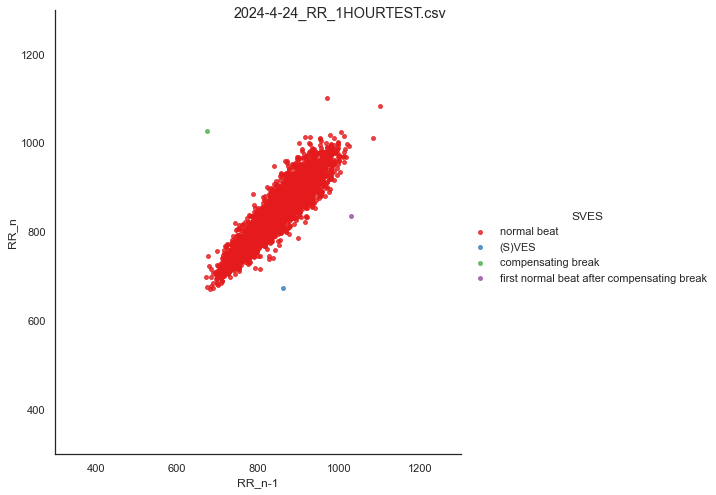

In [15]:
scatterplot(df, None, None)

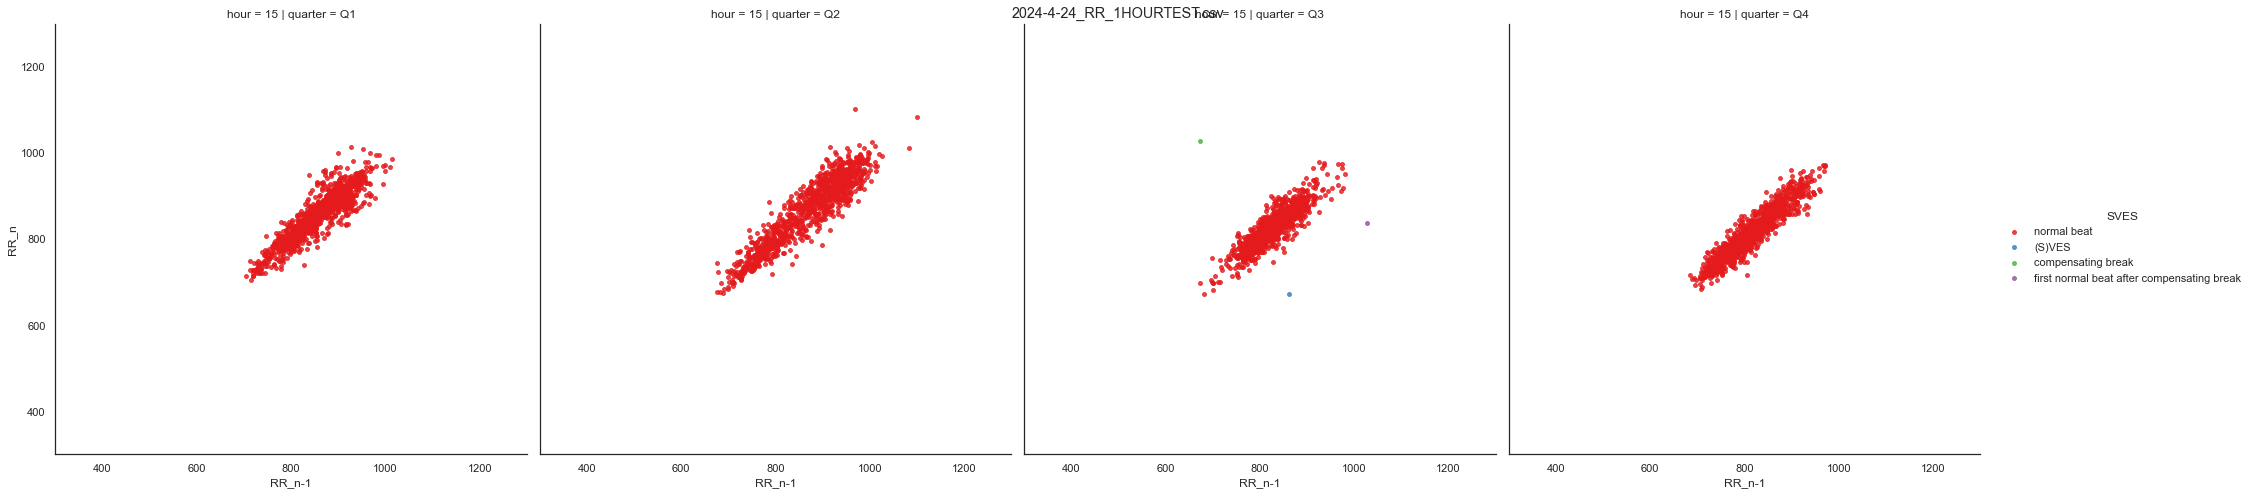

In [16]:
scatterplot(df, 'quarter', 'hour')

In [17]:
df_SVES = df[df['SVES'] == '(S)VES']
df_SVES.shape

(1, 12)

In [18]:
df_SVES.to_excel('outliers.xlsx')

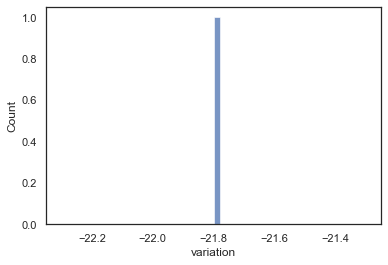

In [19]:
sns.histplot(data=df_SVES, x='variation', bins=50)
plt.show()

In [20]:
#df_variation.loc[df_variation['variation'].idxmax()]

In [21]:
outliers_percentage=(df_SVES.shape[0]/df.shape[0])*100

In [22]:
print ('Sum of Milliseconds = ', measured_time)
print ('Measured Time = ', hours, ' hours', ' = ', minutes, ' minutes')
print ('Beats = ', df.shape[0])
print ('average BPM = ', (df.shape[0]/minutes).round(1))
print ('(S)VES = ', df_SVES.shape[0])
print ('(S)VES% = ',round(outliers_percentage, 1), ' %')

Sum of Milliseconds =  3597710
Measured Time =  1.0  hours  =  60.0  minutes
Beats =  4269
average BPM =  71.2
(S)VES =  1
(S)VES% =  0.0  %
